In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = pd.read_csv('/content/train_en.tsv', sep='\t')

In [ ]:
df.head()

,id,text,HS,TR,AG
0,201,"Hurray, saving us $$$ in so many ways @potus @...",1,0,0
1,202,Why would young fighting age men be the vast m...,1,0,0
2,203,@KamalaHarris Illegals Dump their Kids at the ...,1,0,0
3,204,NY Times: 'Nearly All White' States Pose 'an A...,0,0,0
4,205,Orban in Brussels: European leaders are ignori...,0,0,0


In [ ]:
df.isnull().sum()

,0
id,0
text,0
HS,0
TR,0
AG,0


<ipython-input-6-bf1c3a302453>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['HS'].value_counts() ,y=['Not Hate Speech','Hate Speech'] ,palette='coolwarm')


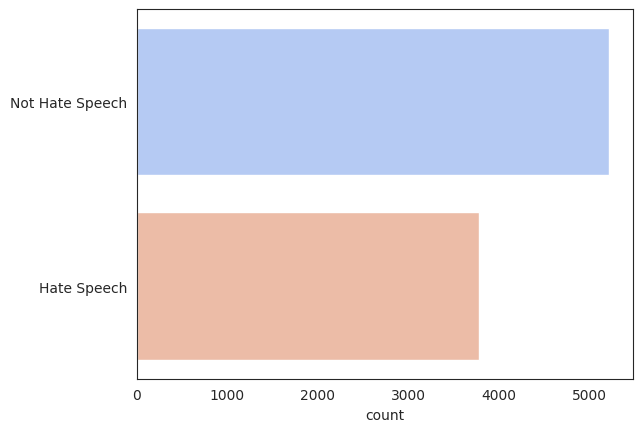

In [ ]:
import seaborn as sns
sns.set_style('white')
sns.barplot(x=df['HS'].value_counts() ,y=['Not Hate Speech','Hate Speech'] ,palette='coolwarm')
plt.show()

In [ ]:
df['TR'].value_counts()

,count
TR,
0,7659
1,1341


In [ ]:
df['AG'].value_counts()

,count
AG,
0,7440
1,1559
discredit,1


In [ ]:
def preprocess(text):

    text = text.lower()

    translate_ = str.maketrans('', '', string.punctuation)
    text = text.translate(translate_)


    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    words = word_tokenize(text)

    stop_words = set(stopwords.words('english','spanish'))
    words = [word for word in words if word not in stop_words]
    exclude =string.punctuation
    words = [word for word in words if word not in exclude]


    lemmatizer = WordNetLemmatizer()
    l=[]
    for word in words:
        l.append(lemmatizer.lemmatize(word))
    text = ' '.join(l)
    return text



In [ ]:
df['text']

,text
0,"Hurray, saving us $$$ in so many ways @potus @..."
1,Why would young fighting age men be the vast m...
2,@KamalaHarris Illegals Dump their Kids at the ...
3,NY Times: 'Nearly All White' States Pose 'an A...
4,Orban in Brussels: European leaders are ignori...
...,...
8995,@mmdwriter @JRubinBlogger @BenSasse I am proud...
8996,@CheriJacobus Hollywood is complicit in the ra...
8997,@amaziah_filani What a fucking cunt I hate see...
8998,Hysterical woman like @CoryBooker


In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Apply preprocessing
df['processed_text'] = df['text'].apply(preprocess)

In [ ]:
df['processed_text']

,processed_text
0,hurray saving u many way potus realdonaldtrump...
1,would young fighting age men vast majority one...
2,kamalaharris illegals dump kid border like roa...
3,ny time nearly white state pose array problem ...
4,orban brussels european leader ignoring people...
...,...
8995,mmdwriter jrubinblogger bensasse proud hysteri...
8996,cherijacobus hollywood complicit rape sexual a...
8997,amaziahfilani fucking cunt hate seeing kid get...
8998,hysterical woman like corybooker


In [ ]:
df.columns

Index(['id', 'text', 'HS', 'TR', 'AG', 'processed_text'], dtype='object')

In [ ]:
df.head()

,id,text,HS,TR,AG,processed_text
0,201,"Hurray, saving us $$$ in so many ways @potus @...",1,0,0,hurray saving u many way potus realdonaldtrump...
1,202,Why would young fighting age men be the vast m...,1,0,0,would young fighting age men vast majority one...
2,203,@KamalaHarris Illegals Dump their Kids at the ...,1,0,0,kamalaharris illegals dump kid border like roa...
3,204,NY Times: 'Nearly All White' States Pose 'an A...,0,0,0,ny time nearly white state pose array problem ...
4,205,Orban in Brussels: European leaders are ignori...,0,0,0,orban brussels european leader ignoring people...


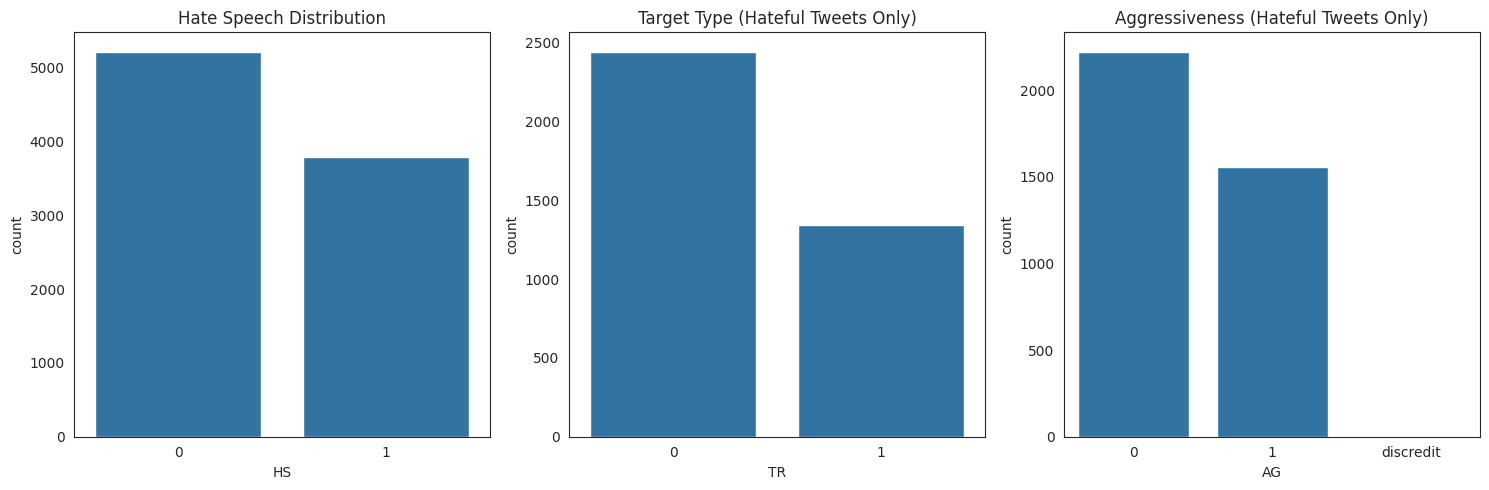

In [ ]:
# EDA
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x='HS', data=df)
plt.title('Hate Speech Distribution')

plt.subplot(1, 3, 2)
sns.countplot(x='TR', data=df[df['HS'] == 1])
plt.title('Target Type (Hateful Tweets Only)')

plt.subplot(1, 3, 3)
sns.countplot(x='AG', data=df[df['HS'] == 1])
plt.title('Aggressiveness (Hateful Tweets Only)')

plt.tight_layout()
plt.show()

###Multilingual Text Vectorization

In [ ]:
# Parameters
max_words = 10000
max_len = 100

# Single tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['processed_text'])

def vectorize_data(df, tokenizer):
    sequences = tokenizer.texts_to_sequences(df['processed_text'])
    padded = pad_sequences(sequences, maxlen=max_len)
    return padded

# Vectorize data
X = vectorize_data(df, tokenizer)

# Get labels
y_hs = df['HS'].values
y_tr = df['TR'].values
y_ag = df['AG'].values

# Split data
X_train, X_test, y_train_hs, y_test_hs, y_train_tr, y_test_tr, y_train_ag, y_test_ag = train_test_split(
    X, y_hs, y_tr, y_ag, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train_hs.shape, y_test_hs.shape, y_train_tr.shape, y_test_tr.shape, y_train_ag.shape, y_test_ag.shape

((7200, 100),
 (1800, 100),
 (7200,),
 (1800,),
 (7200,),
 (1800,),
 (7200,),
 (1800,))

#Task A: Hate Speech Detection Model

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [ ]:
max_len=100
max_words=20000

In [ ]:
input_layer = Input(shape=(max_len,))

In [ ]:
input_layer

<KerasTensor shape=(None, 100), dtype=float32, sparse=False, name=keras_tensor_34>

In [ ]:
# Single processing pipeline
embedding = Embedding(max_words, 128)(input_layer)
lstm = Bidirectional(LSTM(64))(embedding)

In [ ]:
# Common layers
dense = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(lstm)
dropout = Dropout(0.5)(dense)
output_hs = Dense(1, activation='sigmoid', name='hs_output')(dropout)

model_hs = Model(inputs=input_layer, outputs=output_hs)

model_hs.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

In [ ]:
model_hs.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_6 (Embedding)              │ (None, 100, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hs_output (Dense)                    │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,667,137 (10.17 MB)

 Trainable params: 2,667,137 (10.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history_hs = model_hs.fit(
    X_train, y_train_hs,  # Use original data without language indicator
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.5923 - auc_3: 0.5854 - loss: 1.2838 - precision_3: 0.5958 - recall_3: 0.1867 - val_accuracy: 0.7549 - val_auc_3: 0.8227 - val_loss: 0.7011 - val_precision_3: 0.7049 - val_recall_3: 0.7131
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8331 - auc_3: 0.8906 - loss: 0.5541 - precision_3: 0.8149 - recall_3: 0.7885 - val_accuracy: 0.7632 - val_auc_3: 0.8325 - val_loss: 0.5513 - val_precision_3: 0.7339 - val_recall_3: 0.6816
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8919 - auc_3: 0.9456 - loss: 0.3352 - precision_3: 0.8669 - recall_3: 0.8807 - val_accuracy: 0.7382 - val_auc_3: 0.8158 - val_loss: 0.5936 - val_precision_3: 0.6662 - val_recall_3: 0.7512
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9329 - auc_3: 0.9761 - loss: 0.2209 - precision_3: 0.9160 - recall_3: 0.9292 - val_accuracy: 0.7139 - val_auc_3: 0.7944 - val_loss: 0.7092 - val_precision_3: 0.6411 - val_recal

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Task A - Hate Speech Detection Results:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1060
           1       0.73      0.71      0.72       740

    accuracy                           0.77      1800
   macro avg       0.77      0.76      0.77      1800
weighted avg       0.77      0.77      0.77      1800



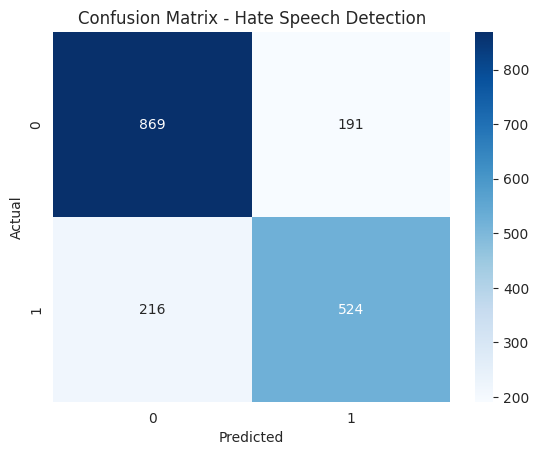

In [ ]:
# Evaluate
y_pred_hs = (model_hs.predict(X_test) > 0.5).astype("int32")

print("Task A - Hate Speech Detection Results:")
print(classification_report(y_test_hs, y_pred_hs))

# Confusion matrix
cm = confusion_matrix(y_test_hs, y_pred_hs)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Hate Speech Detection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

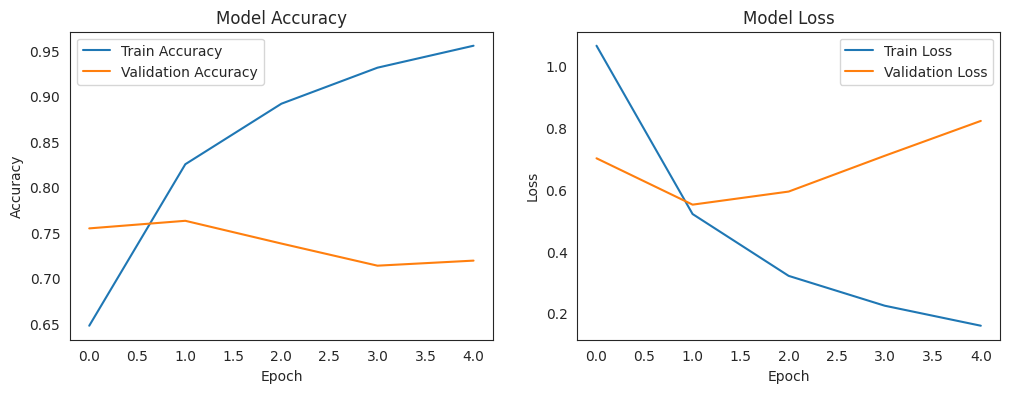

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_hs.history['accuracy'], label='Train Accuracy')
plt.plot(history_hs.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_hs.history['loss'], label='Train Loss')
plt.plot(history_hs.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

# Save tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

def predict_hate_speech(text):
    # Preprocess input text
    processed_text = preprocess(text)  # Use your preprocessing function

    # Tokenize and pad
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)

    # Make prediction
    prediction = model_hs.predict(padded_sequence)[0][0]

    # Return result
    return {
        'text': text,
        'hate_speech_probability': float(prediction),
        'prediction': 'Hate Speech' if prediction > 0.5 else 'Not Hate Speech'
    }

# Test prediction
sample_text = "This is a test tweet with offensive language"
print(predict_hate_speech(sample_text))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
{'text': 'This is a test tweet with offensive language', 'hate_speech_probability': 0.09473628550767899, 'prediction': 'Not Hate Speech'}


#TASK B - Aggressive behavior and Target Classification: where systems are asked first to classify hateful tweets for English and Spanish (e.g., tweets where Hate Speech against women or immigrants has been identified) as aggressive or not aggressive, and second to identify the target harassed as individual or generic (i.e. single human or group

In [ ]:
print("Unique values in y_train_tr_b:", np.unique(y_train_tr_b))
print("Unique values in y_train_ag_b:", np.unique(y_train_ag_b))

Unique values in y_train_tr_b: [1.]
Unique values in y_train_ag_b: [1.]


In [ ]:
y_train_tr_b = np.where(y_train_tr_b == 'individual', 0, 1)
y_test_tr_b = np.where(y_test_tr_b == 'individual', 0, 1)


In [ ]:
y_train_ag_b = np.where(y_train_ag_b == 'non-aggressive', 0, 1)
y_test_ag_b = np.where(y_test_ag_b == 'non-aggressive', 0, 1)

In [ ]:
y_train_ag_b

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
# Now convert to float32
y_train_tr_b = y_train_tr_b.astype('float32')
y_train_ag_b = y_train_ag_b.astype('float32')
y_test_tr_b = y_test_tr_b.astype('float32')
y_test_ag_b = y_test_ag_b.astype('float32')


In [ ]:
# Verify the conversion
print("\nAfter conversion:")
print("Unique values in y_train_tr_b:", np.unique(y_train_tr_b))
print("Unique values in y_train_ag_b:", np.unique(y_train_ag_b))
print("Data types:", y_train_tr_b.dtype, y_train_ag_b.dtype)


After conversion:
Unique values in y_train_tr_b: [1.]
Unique values in y_train_ag_b: [1.]
Data types: float32 float32


In [ ]:
input_layer_b = Input(shape=(max_len,))
embedding_b = Embedding(input_dim=max_words, output_dim=128)(input_layer_b)
lstm_b = Bidirectional(LSTM(64))(embedding_b)
dense_b = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(lstm_b)
dropout_b = Dropout(0.5)(dense_b)

output_tr = Dense(1, activation='sigmoid', name='tr_output')(dropout_b)
output_ag = Dense(1, activation='sigmoid', name='ag_output')(dropout_b)

model_task_b = Model(inputs=input_layer_b, outputs=[output_tr, output_ag])

model_task_b.compile(
    optimizer='adam',
    loss={'tr_output': 'binary_crossentropy', 'ag_output': 'binary_crossentropy'},
    metrics={'tr_output': ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
             'ag_output': ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]},
    loss_weights={'tr_output': 1.0, 'ag_output': 1.0}
)


In [ ]:
# Train the model
history_b = model_task_b.fit(
    X_train_b,
    {'tr_output': y_train_tr_b, 'ag_output': y_train_ag_b},
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - ag_output_accuracy: 0.8888 - ag_output_loss: 0.3702 - ag_output_precision_11: 1.0000 - ag_output_recall_11: 0.8888 - loss: 1.4508 - tr_output_accuracy: 0.9164 - tr_output_loss: 0.3478 - tr_output_precision_10: 1.0000 - tr_output_recall_10: 0.9164 - val_ag_output_accuracy: 1.0000 - val_ag_output_loss: 4.2452e-04 - val_ag_output_precision_11: 1.0000 - val_ag_output_recall_11: 1.0000 - val_loss: 0.4910 - val_tr_output_accuracy: 1.0000 - val_tr_output_loss: 3.6350e-04 - val_tr_output_precision_10: 1.0000 - val_tr_output_recall_10: 1.0000
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - ag_output_accuracy: 1.0000 - ag_output_loss: 0.0070 - ag_output_precision_11: 1.0000 - ag_output_recall_11: 1.0000 - loss: 0.4382 - tr_output_accuracy: 1.0000 - tr_output_loss: 0.0049 - tr_output_precision_10: 1.0000 - tr_output_recall_10: 1.0000 - val_ag_output_accuracy: 1.0000 - val_ag_output_loss: 2.3245e-04 - val_ag_output_precision_11: 1.0000 - va

In [ ]:
# Evaluate on test set
test_results = model_task_b.evaluate(
    X_test_b,
    {'tr_output': y_test_tr_b, 'ag_output': y_test_ag_b},
    verbose=1
)

# Print evaluation metrics
print("\nTest Loss:", test_results[0])
print("Target Classification (TR) - Test Accuracy:", test_results[3])
print("Aggressiveness (AG) - Test Accuracy:", test_results[7])

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - ag_output_accuracy: 1.0000 - ag_output_loss: 1.5257e-04 - ag_output_precision_11: 1.0000 - ag_output_recall_11: 1.0000 - loss: 0.0091 - tr_output_accuracy: 1.0000 - tr_output_loss: 8.5855e-05 - tr_output_precision_10: 1.0000 - tr_output_recall_10: 1.0000

Test Loss: 0.00914714951068163
Target Classification (TR) - Test Accuracy: 1.0
Aggressiveness (AG) - Test Accuracy: 1.0


In [ ]:
# Generate predictions
y_pred_tr, y_pred_ag = model_task_b.predict(X_test_b)
y_pred_tr = (y_pred_tr > 0.5).astype("int32")
y_pred_ag = (y_pred_ag > 0.5).astype("int32")

# Classification reports
print("\nTask B - Target Classification (TR) Results:")
print(classification_report(y_test_tr_b, y_pred_tr))

print("\nTask B - Aggressiveness (AG) Classification Results:")
print(classification_report(y_test_ag_b, y_pred_ag))

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

Task B - Target Classification (TR) Results:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       740

    accuracy                           1.00       740
   macro avg       1.00      1.00      1.00       740
weighted avg       1.00      1.00      1.00       740


Task B - Aggressiveness (AG) Classification Results:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       740

    accuracy                           1.00       740
   macro avg       1.00      1.00      1.00       740
weighted avg       1.00      1.00      1.00       740



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


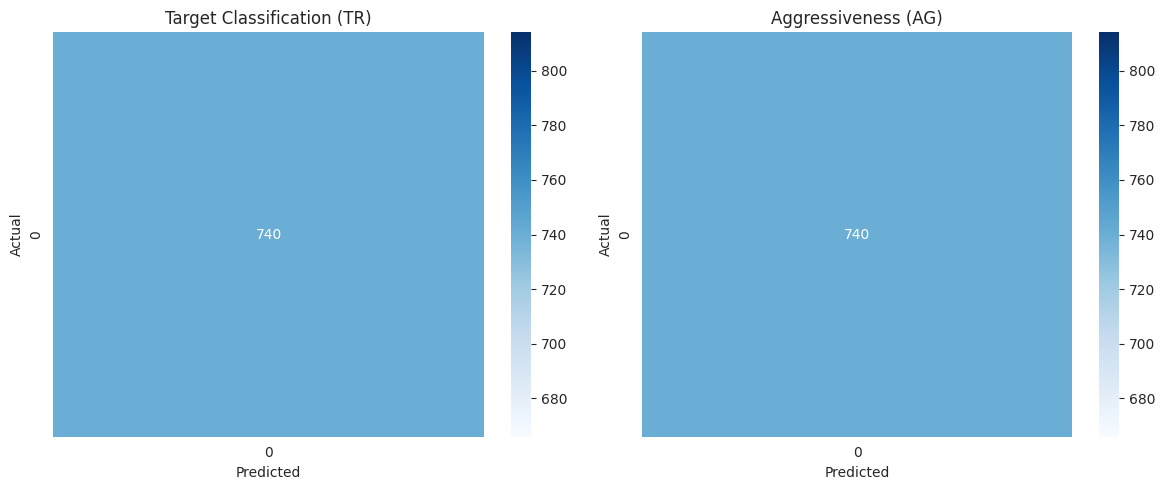

In [ ]:
# Confusion matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test_tr_b, y_pred_tr),
            annot=True, fmt='d', cmap='Blues')
plt.title('Target Classification (TR)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test_ag_b, y_pred_ag),
            annot=True, fmt='d', cmap='Blues')
plt.title('Aggressiveness (AG)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

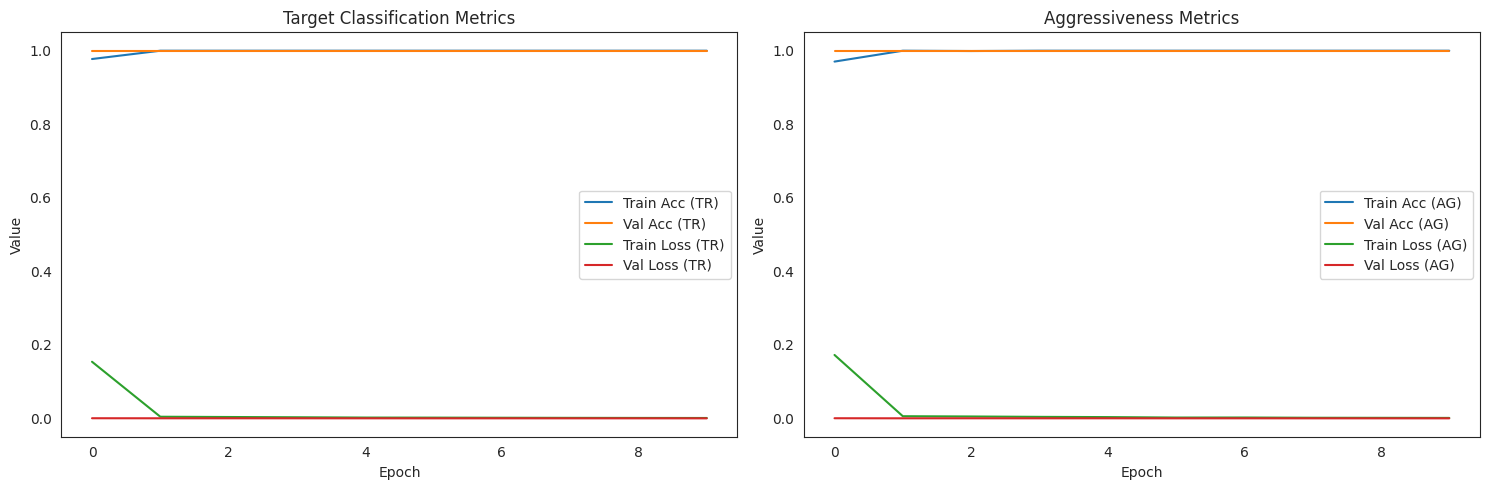

In [ ]:
# Plot training history
plt.figure(figsize=(15, 5))

# Target Classification (TR) metrics
plt.subplot(1, 2, 1)
plt.plot(history_b.history['tr_output_accuracy'], label='Train Acc (TR)')
plt.plot(history_b.history['val_tr_output_accuracy'], label='Val Acc (TR)')
plt.plot(history_b.history['tr_output_loss'], label='Train Loss (TR)')
plt.plot(history_b.history['val_tr_output_loss'], label='Val Loss (TR)')
plt.title('Target Classification Metrics')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend()

# Aggressiveness (AG) metrics
plt.subplot(1, 2, 2)
plt.plot(history_b.history['ag_output_accuracy'], label='Train Acc (AG)')
plt.plot(history_b.history['val_ag_output_accuracy'], label='Val Acc (AG)')
plt.plot(history_b.history['ag_output_loss'], label='Train Loss (AG)')
plt.plot(history_b.history['val_ag_output_loss'], label='Val Loss (AG)')
plt.title('Aggressiveness Metrics')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model
model_task_b.save('hate_speech_task_b_model.h5')

# Save tokenizer (if not already saved)
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)